# Install depencies using pip

* Pillow
* Numpy
* PyTorch
* Matplotlib

In [1]:
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install matplotlib Pillow numpy

Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Define the directory of the project

The project was made using the google colab, so, i've made a mount of my own Drive. But if you're not using the Colab it will change automatically to traditional path of the project.

In [2]:
DIR = "./drive/My Drive/Colab Notebooks/style-transfer"

try:
    from google.colab import drive

    drive.flush_and_unmount()
    drive.mount('/content/drive')
except:
    DIR = "."

Mounted at /content/drive


# Import dependecies


In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

<br/>
<br/>

## Define the device CPU or GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using Device:", device, "\n")

Using Device: cuda 



<br/>
<br/>

## Get the model and disable the parameters to do not train

In [5]:
vgg = models.vgg19(pretrained=True).features

# Stop the train for each parameter
for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Create a function to load the images

In [0]:
def get_image(path, max_size = 400):
    image = Image.open(path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    transform_pipe = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    image = transform_pipe(image)[:3, :, :].unsqueeze(0)

    return image

# Convert ther tensor into image in numpy

In [0]:
def convert_tensor_to_img(tensor):

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

<br/>
<br/>

# Get the gram matrix

In [0]:
def gram_matrix(tensor):

    _, d, h, w = tensor.size()
    gram = tensor.view(d, h * w)
    gram = gram.mm(gram.t())

    return gram

<br/>
<br/>

## Extract the features from the VGG19

In [0]:
def extract_features_vgg(image, model, layers=None):

    if layers is None:
        layers = {
            '0': 'Conv_1_1',
            '5': 'Conv_2_1',
            '10': 'Conv_3_1',
            '19': 'Conv_4_1',
            '21': 'Conv_4_2',
            '28': 'Conv_5_1'
        }

    
    features = {}
    X = image
    for name, layer in model._modules.items():
        X = layer(X)

        if name in layers:
            features[ layers[name] ] = X
    
    return features

<br/>
<br/>

## Define the train to obtain the Target image

\begin{equation*}
\Large loss_{content} = \frac{1}{2} \times \sum (S_{feat} - C_{feat}) ^ 2
\end{equation*}

\begin{equation*}
\Large loss_{style} = \sigma \times \sum (T_{grams} - S_{grams}) ^ 2
\end{equation*}

<br>
<br>

\begin{equation*}
\Large loss_{total} = W_{content} \times loss_{content} + W_{style} \times loss_{style}
\end{equation*}

In [0]:
def fit_target(model, content, style, content_weight = 1, style_weight = 1e5, extract_features=extract_features_vgg, layer_weights=None, epochs=2000, show_batch=500, lr=0.03):

    if layer_weights == None:
        layer_weights = {
            'Conv_1_1': 1.0,
            'Conv_2_1': 0.8,
            'Conv_3_1': 0.6,
            'Conv_4_1': 0.4,
            'Conv_4_2': 0.2,
            'Conv_5_1': 0.1
        }

    # Get the features of the model from each image
    content_features = extract_features(content, model)
    style_features = extract_features(style, model)

    # Get the gram matrix from the style
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # Create the target image from copy the content
    target = content.clone().requires_grad_(True).to(device)

    # Define the optmizer
    optmizer = torch.optim.Adam([target], lr=lr)

    for e in range(epochs):

        style_loss = 0

        target_features = extract_features(target, model)
        target_grams = {layer: gram_matrix(target_features[layer]) for layer in target_features}

        content_loss = torch.mean( ( style_features['Conv_4_2'] - content_features['Conv_4_2'] ) ** 2 )

        for layer in layer_weights:
            _, d, h, w = target_features[layer].shape

            layer_style_loss = layer_weights[ layer ] * torch.mean( ( target_grams[layer] - style_grams[layer] ) ** 2 )
            style_loss += layer_style_loss / (d * h * w)
        
        total_loss = content_weight * content_loss + style_weight * style_loss

        optmizer.zero_grad()
        total_loss.backward()
        optmizer.step()

        if  (e+1) % 500 == 0:
            print('Total loss: ', total_loss.item())
            plt.imshow(convert_tensor_to_img(target))
            plt.show()
        
    return target

<br/>
<br/>

# The Persistence of Memory
> Salvador Dali

In [0]:
content = get_image(f'{DIR}/images/Recife.jpg').to(device)
style = get_image(f'{DIR}/images/Surrealism.jpg').to(device)

### Plot the content and style 

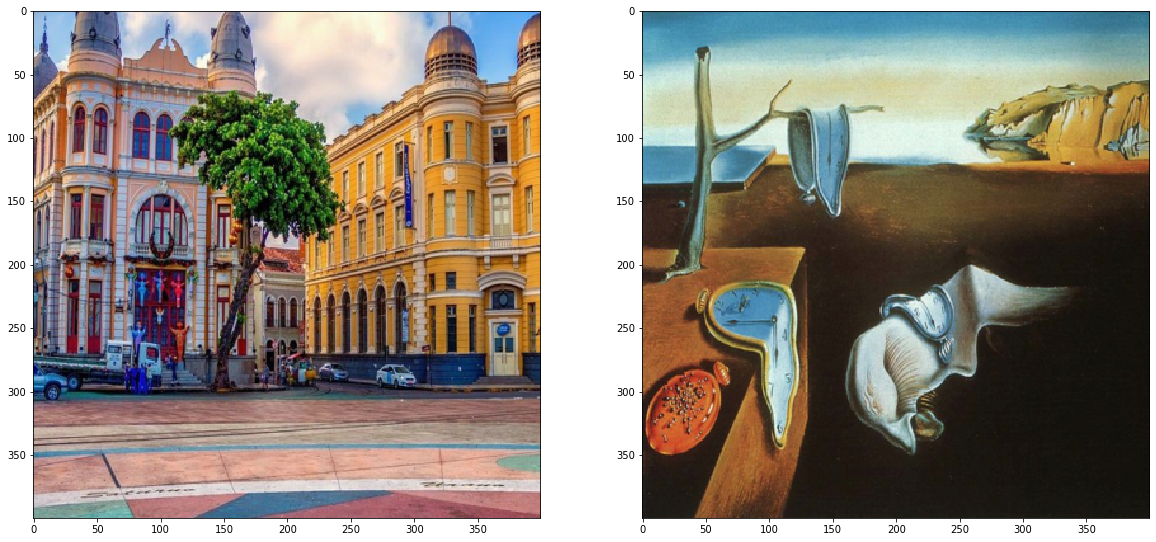

In [12]:
_, axis = plt.subplots(1, 2, figsize=(20, 10))

axis[0].imshow(convert_tensor_to_img(content))
axis[1].imshow(convert_tensor_to_img(style))

plt.show()

### Train

In [0]:
target = fit_target(vgg, content, style, epochs=100, show_batch=50)

<br/>
<br/>

## Recife Before | Recife After

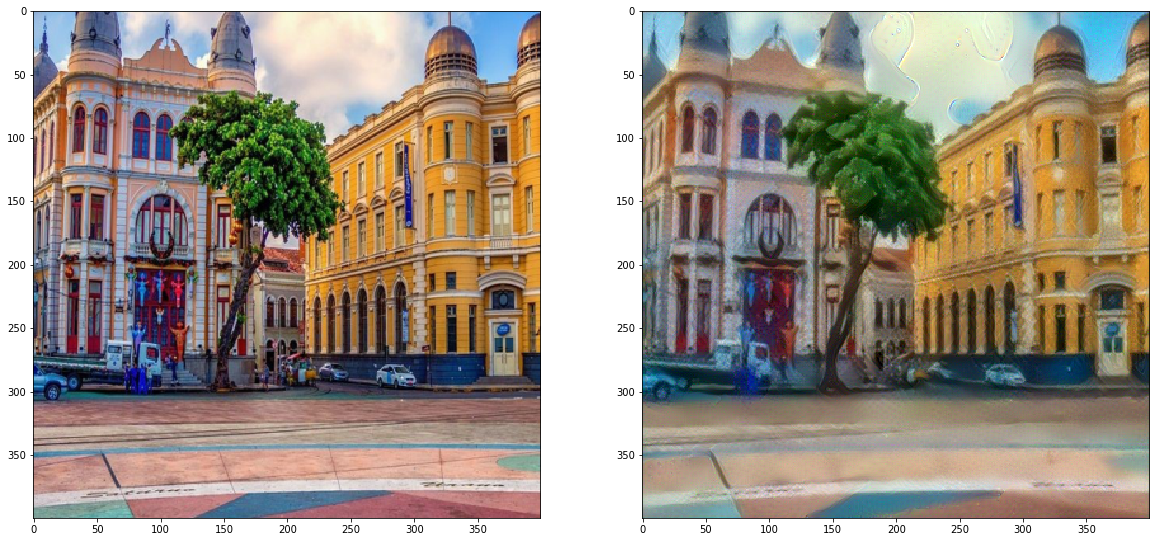

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_tensor_to_img(content))
ax2.imshow(convert_tensor_to_img(target))

<br/>
<br/>

# The Scream
> Edvard Munch

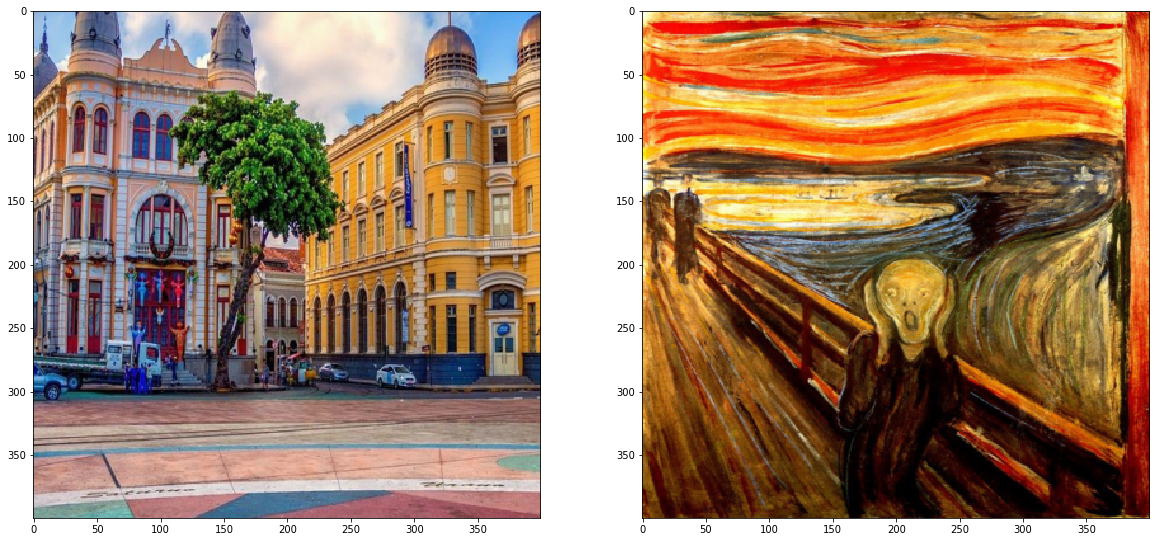

In [15]:
content = get_image(f'{DIR}/images/Recife.jpg').to(device)
style = get_image(f'{DIR}/images/TheScream.jpg').to(device)

_, axis = plt.subplots(1, 2, figsize=(20, 10))

axis[0].imshow(convert_tensor_to_img(content))
axis[1].imshow(convert_tensor_to_img(style))

Total loss:  1795.6097412109375


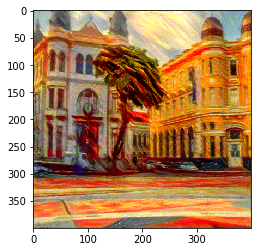

In [16]:
target = fit_target(vgg, content, style, style_weight=1e3, epochs=500, show_batch=250)

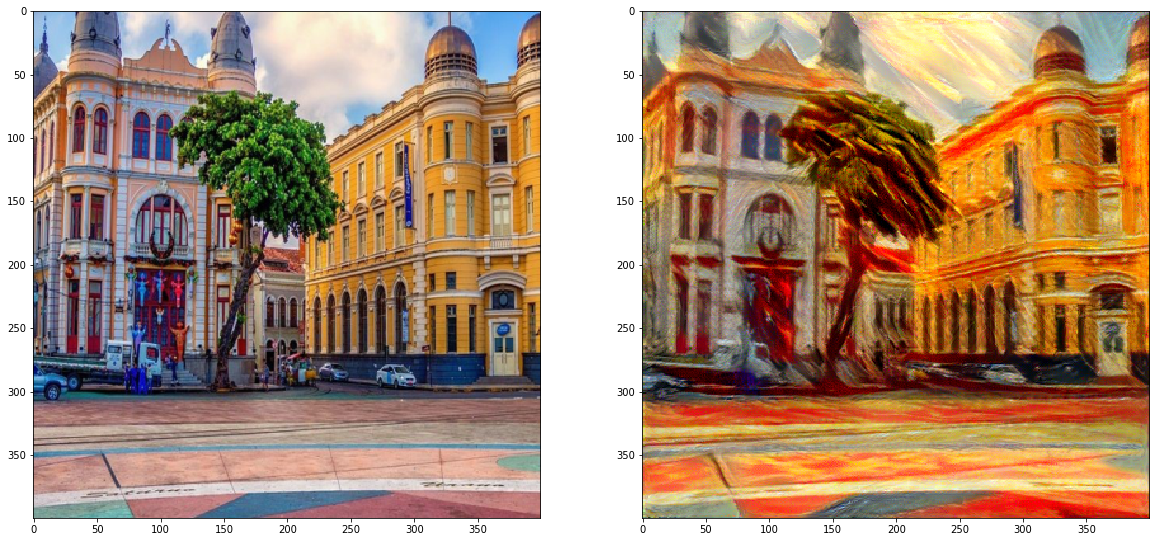

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_tensor_to_img(content))
ax2.imshow(convert_tensor_to_img(target))

<br/>
<br/>

# Brushstroke style

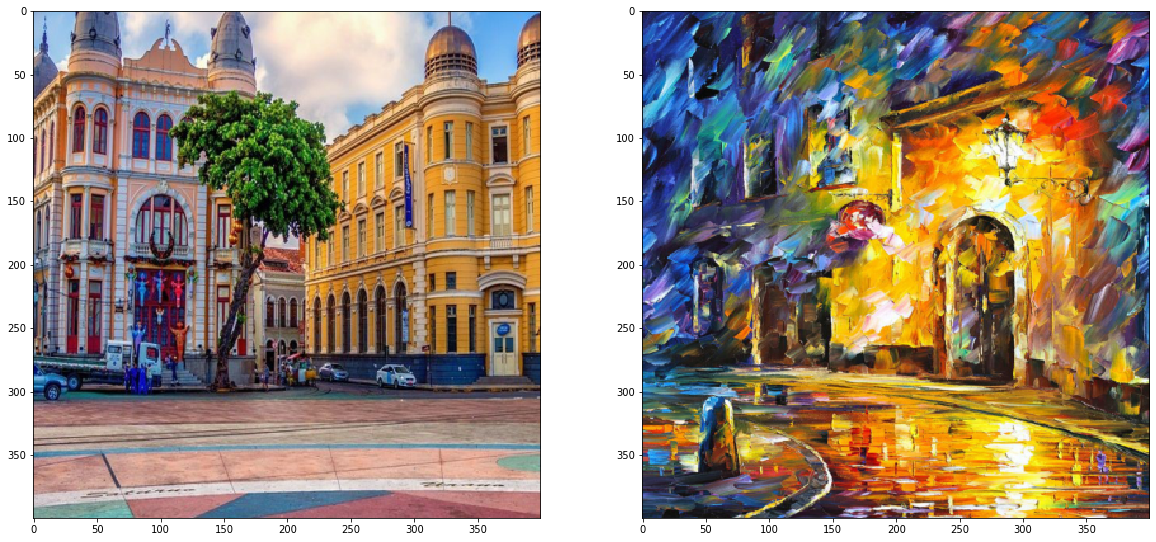

In [18]:
content = get_image(f'{DIR}/images/Recife.jpg').to(device)
style = get_image(f'{DIR}/images/BrushImage.jpg').to(device)

_, axis = plt.subplots(1, 2, figsize=(20, 10))

axis[0].imshow(convert_tensor_to_img(content))
axis[1].imshow(convert_tensor_to_img(style))

Total loss:  131014.796875


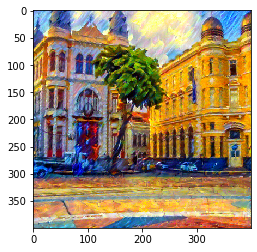

Total loss:  73165.5859375


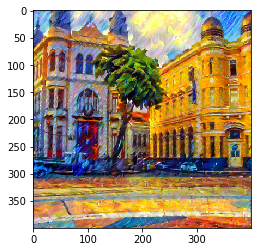

In [19]:
target = fit_target(vgg, content, style, epochs=1000, show_batch=1000)

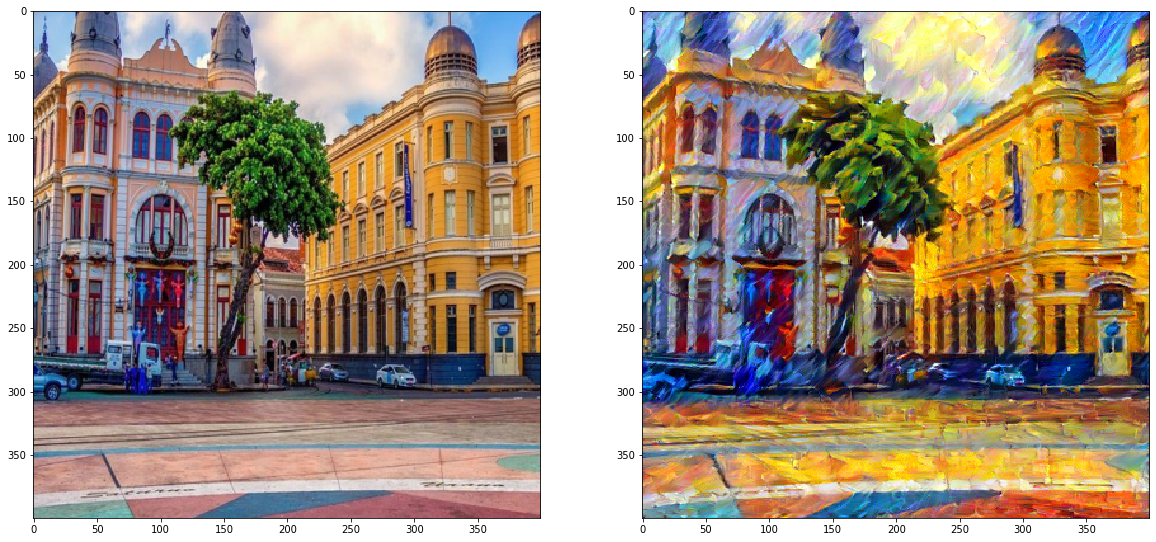

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_tensor_to_img(content))
ax2.imshow(convert_tensor_to_img(target))